In [66]:
#! /usr/bin/env python 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import use
#use('Agg')
%matplotlib inline



# Generation of Fast-JX photolysis files for exoplanets

## BT-Settl regridding

In [67]:
#Read in BT-Settl file (see http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl)

data = pd.read_csv("../bt-settl/mdwrf3000_g5/lte030-5.0+0.3a+0.0.BT-NextGen.7.dat.txt", 
                   delim_whitespace=True, comment="#", names=["wavelength", "flux"]) 

# Ensure they're sorted
data = data.sort_values("wavelength")

# Convert to nm 
data.wavelength = 0.1 * data.wavelength

# Chop down to the wavelength range we're interested in
data = data.ix[data.apply(lambda d: 95.0 <= d.wavelength <= 2150.0, 1)] 
# Reset indices
data = data.reset_index(drop=True) 

# Get intervals between bands
# First find midpoint between wavelengths
last = data.last_valid_index()
intervals = np.zeros_like(data.wavelength)
intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() + 
                 data.ix[:last - 1, "wavelength"].as_matrix() ) / 2.0
# Extrapolate at both ends
intervals[0]  = 2.0 * data.ix[0, "wavelength"] - intervals[1]
intervals = np.append(intervals, 2.0 * data.ix[last, "wavelength"] - intervals[-1]) 
# Calculate width of each band and add to dataframe
data.ix[:, "widths"] = intervals[1:] - intervals[:-1]

data = data[(data.widths != 0.0)]
data = data.reset_index(drop = True) 

# Regrid onto correct wavelengths 
new_wls = np.arange(100.05, 2100.05, 0.05)
new_wdt = np.full_like(new_wls, 0.05)
new_flx = np.interp(new_wls, data.wavelength, data.flux) 
regrid = pd.DataFrame({"wavelength": new_wls, "flux": new_flx, "widths": new_wdt})

# We're in ergs /cm^2 /A /s
# Convert to photons/s/bin 
# First to photons /cm^2 /A /s
#             Joules         wavelength, nm to m         h          c
regrid.flux *= (1.0e-7 * (1.0e-9 * regrid.wavelength)) / (6.626e-34 * 2.998e8) 

## Convert to bins (convert nm to A)
regrid.flux *= regrid.widths * 10.0 

# Convert from cm^-2 to m^-2
regrid.flux *= 1.0e4

writefile = "mdwrf3000_g5-p05_2100nm.dat" 
f = open(writefile, "w") 

headstr = "Spectra from BTSettl, 3000, logg=5, metal=0.3, alpha=0, converted to photons/s/bin, rebinned(0.05nm)" + "\n" + "(f10.3,e10.3) (wave-nm(i), flux(i), i=1,40000)" + "\n"

f.write(headstr)

for l in regrid.itertuples(): 
    f.write("{0:10.3f}{1:10.3e}\n".format(l.wavelength, l.flux))

f.close()

# print regrid.describe()
# 
# solar = pd.read_csv("../nlabra/FastJX/python_scripts/ukca/data/solar-p05nm-UCI.dat", \
# 	    delim_whitespace=True, names=["wavelength", "flux"], skiprows=2 )
# 
# print solar.describe()

# plt.plot(solar.wavelength,  solar.flux) 
# plt.plot(regrid.wavelength, regrid.flux)
# plt.yscale("log")
# plt.show()
print(regrid)

<ipython-input-67-ba624f40ddda>:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  data = data.ix[data.apply(lambda d: 95.0 <= d.wavelength <= 2150.0, 1)]


       wavelength          flux  widths
0          100.05  1.716743e-06    0.05
1          100.10  2.471013e-11    0.05
2          100.15  7.654066e-07    0.05
3          100.20  7.562598e-09    0.05
4          100.25  1.234855e-09    0.05
...           ...           ...     ...
39995     2099.80  4.594355e+20    0.05
39996     2099.85  5.397999e+20    0.05
39997     2099.90  5.778525e+20    0.05
39998     2099.95  4.805373e+20    0.05
39999     2100.00  3.492260e+20    0.05

[40000 rows x 3 columns]


<ipython-input-67-ba624f40ddda>:21: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() +
/usr/lib/python3/dist-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
<ipython-input-67-ba624f40ddda>:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() +
<ipython-input-67-ba624f40ddda>:22: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See

# MUSCLES regridding

In [68]:
from astropy.table import Table
#Read in MUSCLES file (see https://archive.stsci.edu/prepds/muscles/)

spec = Table.read('../muscles/hlsp_muscles_multi_multi_gj551_broadband_v22_adapt-const-res-sed.fits').to_pandas()
data = pd.DataFrame({"wavelength":spec['WAVELENGTH'], "flux":spec['FLUX']})

# Convert to nm 
data.wavelength = 0.1 * data.wavelength
# Chop down to the wavelength range we're interested in
data = data.ix[data.apply(lambda d: 0.0 < d.wavelength <= 2150.00, 1)] 
# Reset indices
data = data.reset_index(drop=True) 
# Get intervals between bands
# First find midpoint between wavelengths
last = data.last_valid_index()
intervals = np.zeros_like(data.wavelength)
intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() + 
                 data.ix[:last - 1, "wavelength"].as_matrix() ) / 2.0
# Extrapolate at both ends
intervals[0]  = 2.0 * data.ix[0, "wavelength"] - intervals[1]
intervals = np.append(intervals, 2.0 * data.ix[last, "wavelength"] - intervals[-1]) 
# Calculate width of each band and add to dataframe
data.ix[:, "widths"] = intervals[1:] - intervals[:-1]

data = data[(data.widths != 0.0)]
data = data.reset_index(drop = True) 
data
print(data)

# # # Regrid onto correct wavelengths 
new_wls = np.arange(0.05, 2100.05, 0.05)
new_wdt = np.full_like(new_wls, 0.05)
new_flx = np.interp(new_wls, data.wavelength, data.flux) 
regrid = pd.DataFrame({"wavelength": new_wls, "flux": new_flx, "widths": new_wdt})
# We're in ergs /cm^2 /A /s
# Convert to photons/s/bin 
# First to photons /cm^2 /A /s
#             Joules         wavelength, nm to m         h          c
regrid.flux *= (1.0e-7 * (1.0e-9 * regrid.wavelength)) / (6.626e-34 * 2.998e8) 
print(regrid)

## Convert to bins (convert nm to A)
regrid.flux *= regrid.widths * 10.0 

# # Convert from cm^-2 to m^-2
regrid.flux *= 1.0e4

# #regrid.to_csv('mdwrf3000_muscles_p05_2100nm.dat')
writefile = "mdwrf3000_muscles_p05_2100nm.dat" 
f = open(writefile, "w") 

headstr = "Spectra from MUSCLES, converted to photons/m2/s/bin, rebinned(0.05nm)" + "\n" + "(f10.3,e10.3) (wave-nm(i), flux(i), i=1,40000)" + "\n"

f.write(headstr)

for l in regrid.itertuples(): 
    f.write("{0:10.3f}{1:10.3e}\n".format(l.wavelength,l.flux))

f.close()
print(regrid)

<ipython-input-68-cda651e749fc>:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  data = data.ix[data.apply(lambda d: 0.0 < d.wavelength <= 2150.00, 1)]


       wavelength          flux  widths
0         0.29527  8.755898e-14     0.1
1         0.39527  1.304280e-13     0.1
2         0.49527  1.807007e-13     0.1
3         0.59527  1.837131e-13     0.1
4         0.69527  2.212831e-13     0.1
...           ...           ...     ...
21493  2149.59527  7.569997e-13     0.1
21494  2149.69527  6.983954e-13     0.1
21495  2149.79527  7.687498e-13     0.1
21496  2149.89527  7.852997e-13     0.1
21497  2149.99527  6.750751e-13     0.1

[21498 rows x 3 columns]
       wavelength      flux  widths
0            0.05  0.000002    0.05
1            0.10  0.000004    0.05
2            0.15  0.000007    0.05
3            0.20  0.000009    0.05
4            0.25  0.000011    0.05
...           ...       ...     ...
41995     2099.80  0.839747    0.05
41996     2099.85  0.777818    0.05
41997     2099.90  0.724496    0.05
41998     2099.95  0.753582    0.05
41999     2100.00  0.778255    0.05

[42000 rows x 3 columns]
       wavelength         flux  widt

<ipython-input-68-cda651e749fc>:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() +
<ipython-input-68-cda651e749fc>:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals[1:] = (data.ix[1:, "wavelength"].as_matrix() +
<ipython-input-68-cda651e749fc>:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  data.ix[:last - 1, "wavelength"].as_matrix() ) / 2.0
<ipython-input-68-cda651e749fc>:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data.ix[:last - 1, "wavelength"].as

# Comparing the fluxes from the Sun and Prox Cen b

In [70]:
solar = np.loadtxt("solar-p05nm-UCI.dat", skiprows=2)
mdwrf = np.loadtxt("mdwrf3000_g5-p05_2100nm.dat",     skiprows=2)
mdwrf_musc = np.loadtxt("mdwrf3000_muscles_p05_2100nm.dat",     skiprows=2)
h = 6.626e-34
c = 2.998e8

sf = solar[:,1]; sw = solar[:,0] #per cm2
mf = mdwrf[:,1]*10**(-4); mw = mdwrf[:,0]

mfmusc = mdwrf_musc[:,1]*10**(-4); mwmusc = mdwrf_musc[:,0]



In [72]:
#From flux at stellar surface to 1 AU
mf *= ((1.069423083e8/149597870700)**2)

#From flux at 4.2 ly to 1 AU
mfmusc *= ((265613)**2)

# Divide flux by wavelength to get energy
se = sf* h * c / (sw * 1.0e-9)
me = mf* h * c / (mw * 1.0e-9)
memusc = mfmusc* h * c / (mwmusc * 1.0e-9)



writefile = "pcb_1au_musc.dat"  
f = open(writefile, "w")  
 
headl1 = "Spectra from MUSCLES, converted to photons/s/bin, rebinned(0.05nm)\n" 
headl2 = "(f10.3,e10.3) (wave-nm(i), flux(i), i=1,40000)\n" 
 
f.write(headl1) 
f.write(headl2)
 
for i in range(len(mf)):  
    f.write("{0:10.3f}{1:10.3e}\n".format(mwmusc[i], mfmusc[i]))

f.close()

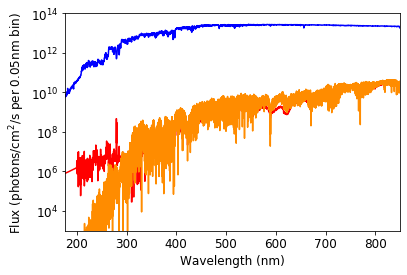

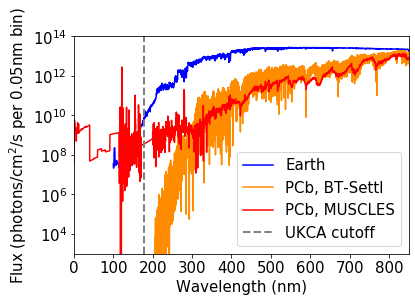

In [74]:
#plt.clf()
#plt.title('TOA flux at 1AU', fontsize=15)
plt.plot(sw, sf, label="Solar", color='blue')
plt.plot(mwmusc, mfmusc, label="M Dwarf,MUSCLES", color='red')
plt.plot(mw, mf, label="M Dwarf,3000K", color='darkorange')
#plt.axhline(1807000)
plt.yscale("log")
plt.ylim([1.0e3, 1.0e14])
plt.xlim([177, 850])
#plt.xlim([mw.min(), mw.max()])
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Flux (photons/cm$^2$/s per 0.05nm bin)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc="lower right", fontsize=12)
plt.show()

#plt.title('TOA flux', fontsize=15)
plt.plot(sw, sf, label="Earth", c='blue')

#plt.plot(mwg3, mfg3*((1.0/0.0485)**2.0), label="Proxima Centauri b, logg=3", c='red')
plt.plot(mw, mf*((1.0/0.0485)**2.0), label="PCb, BT-Settl", c='darkorange')
plt.plot(mwmusc, mfmusc*((1.0/0.0485)**2.0), label="PCb, MUSCLES", color='red')#plt.plot(mw_rib17, mff_rib17/20, label="Ribas 17", c='black')
#plt.plot(tw, tf*((1.0/0.02928285)**2.0), label="T1e, BTS", c='darkgreen')
plt.axvline(177, ls='--', lw=2, color='grey', label='UKCA cutoff')
#plt.axhline(1807000*((1.0/0.0485)**2.0))
plt.yscale("log")
plt.ylim([1.0e3, 1.0e14])
plt.xlim([0, 850])
plt.xlabel("Wavelength (nm)", fontsize=15)
plt.ylabel("Flux (photons/cm$^2$/s per 0.05nm bin)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="lower right", fontsize=15)
#plt.axvline(1190, ls='--', lw=2, color='grey')
plt.axhline(8.357e13,412.5,850)
plt.show()

# Regrid fluxes onto Fast-JX wavelength bins (see Bian and Prather, 2002)

In [76]:
#FJX wavelength bins definition and muscles file
with open("FJX_spec_exochem_new.txt") as FJXfile:
    FJX = FJXfile.readlines()
mdwrf = np.loadtxt('pcb_1au_musc.dat', skiprows=2)

#Writing to FJX_spec file
writefile = "FJX_spec_pcb_musc_1au.txt"
f = open(writefile, "w")  

#Definition of S-R band bins in Fast-JX following UCI standard photolysis model
wlims = [177.49, 178.30, 179.26, 180.38, 181.65, 183.08, 184.65, 186.37, 188.24, 
        190.25, 192.42, 194.73, 197.20, 198.50, 200, 202.50]

#Addition of M-dwarf fluxes to S-R band bins
srbands = np.zeros((16))
for i in range(len(mdwrf)):
    for j in range(len(wlims)):
        if mdwrf[i,0] < wlims[j]:
            srbands[j] += mdwrf[i,1]
            # print mdwrf[i,0], wlims[j], mdwrf[i,1], newf[j]
            break


#Definition of higher wavelength regions treated within Fast-JX
wlimsup = [202.5, 206.5, 209.5, 212.5, 215.5, 221.5, 233, 275.5, 286.5, 291, 298.25, 
        307.45, 312.45, 320.3, 345, 412.45, 850]

#Addition of M-dwarf fluxes to higher wavelength regions
upbins = np.zeros((17))
for i in range(len(mdwrf)):
    for j in range(len(wlimsup)):
        if mdwrf[i,0] < wlimsup[j]:
            upbins[j] += mdwrf[i,1]
            # print mdwrf[i,0], wlims[j], mdwrf[i,1], newf[j]
            break


# Regrouping of wavelength bins following Bian and Prather (2002)

In [78]:
newf=np.zeros(18)
newf[0] = (0.076*srbands[12]+0.148*srbands[11]+0.164*srbands[10]+0.157*srbands[9]+
       0.304*srbands[8]+0.488*srbands[7]+0.553*srbands[6]+0.204*srbands[5]+
       0.321*srbands[4]+0.398*srbands[3]+0.511*srbands[2]+0.241*srbands[1])
newf[1] = (0.098*srbands[13]+0.191*srbands[12]+0.333*srbands[11]+0.299*srbands[10]
        +0.368*srbands[9]+0.243*srbands[8]+0.336*srbands[7]+0.191*srbands[6]+
       0.153*srbands[5])  #***
newf[2] = (0.047*srbands[15]+0.102*srbands[14]+0.198*srbands[13]+0.21*srbands[12]+
        0.281*srbands[11]+0.287*srbands[10]+0.427*srbands[9]+0.224*srbands[8]) #***
newf[3] = 0.142*srbands[14]+0.198*srbands[13]+0.247*srbands[12]+0.238*srbands[11] #***
newf[4] = upbins[1]+0.953*srbands[15]+0.756*srbands[14]+0.506*srbands[13]+0.276*srbands[12] #***
newf[5] = upbins[2]
newf[6] = upbins[3]
newf[7] = 0.157*srbands[10]+upbins[4]
newf[8] = upbins[7]
newf[9] = upbins[6]+upbins[8]
newf[10] = upbins[5]+upbins[9]
newf[11] = upbins[10]
newf[12] = upbins[11]
newf[13] = upbins[12]
newf[14] = upbins[13]
newf[15] = upbins[14]
newf[16] = upbins[15]
newf[17] = upbins[16]
print(newf.sum())
print(mfmusc.sum())
print(newf/mfmusc.sum())

56366099311113.1
1069178983917167.8
[1.02000321e-07 9.45601325e-08 8.64221058e-08 4.25586611e-08
 3.08697501e-07 1.11203729e-07 1.30157066e-07 1.28250427e-07
 4.43240530e-06 5.39961324e-06 5.53870876e-07 6.04838581e-07
 6.43576717e-07 2.42769428e-07 4.75694984e-07 5.38857833e-06
 8.71801367e-05 5.26131237e-02]


# Writing the Fast-JX fluxes to FJX_spec file, giving the fluxes as shown in Table 3 of Braam et al. (2022)

In [79]:
def pw(f, s):
    print("Writing: ", s,)
    f.write(s)

sol1 = "SOL#/cm2/s {:.3E} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E}\n".format(newf[0], 
                                                                       newf[1], 
                                                                       newf[2], 
                                                                       newf[3], 
                                                                       newf[4], 
                                                                       newf[5])
sol2 = "           {:.3E} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E}\n".format(newf[6], 
                                                                       newf[7], 
                                                                       newf[8], 
                                                                       newf[9], 
                                                                       newf[10], 
                                                                       newf[11])
sol3 = "           {:.3E} {:.3E} {:.3E} {:.3E} {:.3E} {:.3E}\n".format(newf[12], 
                                                                       newf[13], 
                                                                       newf[14], 
                                                                       newf[15], 
                                                                       newf[16], 
                                                                       newf[17])
pw(f, FJX[0]) 
pw(f, FJX[1])

wl = np.zeros((18))
for i in range(3):
    pw(f, FJX[2+i])
    wl[6*i:6*i+6] = [float(z) for z in FJX[2+i][11:].split()]


pw(f, sol1)
pw(f, sol2)
pw(f, sol3)

for i in range(8,len(FJX)):
    pw(f, FJX[i])

f.close()

Writing:  CAM v1.0 based on UCI v6.4a [ref-J(4/06b) JPL06+irHNO4+IUPAC/NO2/VOC+Blitz+flux2006+misc 

Writing:  NW-JValues    4    4   18    1   18 NJVAL,NQQQ,NWWW >>>NW1:NW2 not used v6.4

Writing:  w-eff (nm)      187.      191.      193.      196.      202.      208.

Writing:                  211.      214.      261.      267.      277.      295.

Writing:                  303.      310.      316.      333.      380.      574.

Writing:  SOL#/cm2/s 1.091E+08 1.011E+08 9.240E+07 4.550E+07 3.301E+08 1.189E+08

Writing:             1.392E+08 1.371E+08 4.739E+09 5.773E+09 5.922E+08 6.467E+08

Writing:             6.881E+08 2.596E+08 5.086E+08 5.761E+09 9.321E+10 5.625E+13

Writing:  Raylay cm2 5.073E-25 4.479E-25 4.196E-25 3.906E-25 3.355E-25 2.929E-25

Writing:             2.736E-25 2.581E-25 1.049E-25 9.492E-26 8.103E-26 6.131E-26

Writing:             5.422E-26 4.923E-26 4.514E-26 3.643E-26 2.087E-26 3.848E-27

Writing:  jo2    180 1.727E-21 1.989E-22 3.004E-23 9.833E-24 7.306E-24 6.

# Plot comparing high resolution fluxes with Fast-JX bins, reproduction of Figure 1 in Braam et al. (2022)

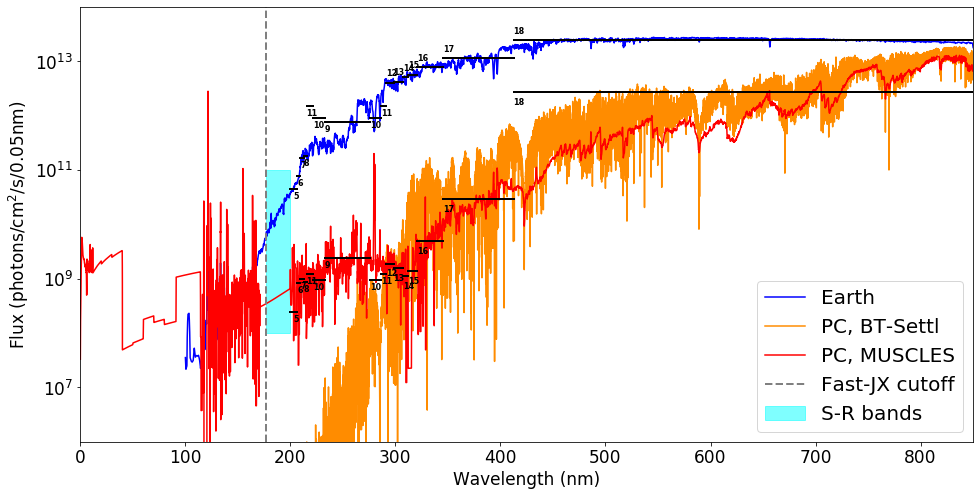

In [81]:
from matplotlib.patches import Rectangle

#Comparing FJX bin distribution with full spectrum for PCb flux
pcbflux_5678=[1.0E+08,1.189E+08,1.392E+08, 1.371E+08]
pcbflux_91011=[4.739E+09,1.0E+09,5.922E+08]
pcbflux=[6.467E+08,6.881E+08,2.596E+08,5.086E+08,5.761E+09,9.321E+10,5.625E+13]

##Solar flux at Earth
solflux_5678=[7.842E+12,4.680E+12, 9.918E+12, 1.219E+13]
solflux_91011=[6.364E+14, 4.049E+14, 3.150E+14]
solflux=[5.889E+14, 7.678E+14, 5.045E+14, 8.902E+14, 3.853E+15, 1.547E+16, 2.131E+17]

#Definition of Fast-JX bin bounds
wlim_l= [291, 298.25, 307.45, 312.45, 320.3, 345, 412.45]
wlim_u= [298.25, 307.45, 312.45, 320.3, 345, 412.45, 850]

bin9_wl=[233,275.5]
bin10_wl=[221.5,233,275.5,286.5]
bin11_wl=[215.5,221.5,286.5,291]

bins_5678_l=[202.5,206.5,209.5,212.5]
bins_5678_u=[206.5,209.5,212.5,215.5]


plt.figure(figsize=(16,8))
plt.plot(sw, sf, label="Earth", c='blue')
plt.plot(mw,mf*((1.0/0.0485)**2.0), label="PC, BT-Settl", c='darkorange')
plt.plot(mwmusc, mfmusc*((1.0/0.0485)**2.0), label="PC, MUSCLES", color='red')

##bin5
plt.plot([200,206.5], [((1.0/0.0485)**2.0)*pcbflux_5678[0]/(20*8.85752), 
                        ((1.0/0.0485)**2.0)*pcbflux_5678[0]/(20*8.85752)],lw=2,color='black')
plt.annotate(str(5), fontsize=8, fontweight='bold', xy=((bins_5678_l[0]),
                        ((1.0/0.0485)**2.0)*pcbflux_5678[0]/(30*8.85752)))
plt.plot([200,206.5], [solflux_5678[0]/(20*8.85752), 
                        solflux_5678[0]/(20*8.85752)],lw=2,color='black')
plt.annotate(str(5), fontsize=8, fontweight='bold', xy=((bins_5678_l[0]),
                        solflux_5678[0]/(30*8.85752)))
##bin6
plt.plot([206.5,209.5], [((1.0/0.0485)**2.0)*pcbflux_5678[1]/(20*3), 
                        ((1.0/0.0485)**2.0)*pcbflux_5678[1]/(20*3)],lw=2,color='black')
plt.annotate(str(6), fontsize=8, fontweight='bold', xy=((bins_5678_l[1]),
                        ((1.0/0.0485)**2.0)*pcbflux_5678[1]/(30*3)))
plt.plot([206.5,209.5], [solflux_5678[1]/(20*3), 
                        solflux_5678[1]/(20*3)],lw=2,color='black')
plt.annotate(str(6), fontsize=8, fontweight='bold', xy=((bins_5678_l[1]),
                        solflux_5678[1]/(30*3)))
##bin7
plt.plot([209.5,212.5], [((1.0/0.0485)**2.0)*pcbflux_5678[2]/(20*3), 
                        ((1.0/0.0485)**2.0)*pcbflux_5678[2]/(20*3)],lw=2,color='black')
plt.annotate(str(7), fontsize=8, fontweight='bold', xy=((bins_5678_l[2]),
                        ((1.0/0.0485)**2.0)*pcbflux_5678[2]/(30*3)))
plt.plot([209.5,212.5], [solflux_5678[2]/(20*3), 
                        solflux_5678[2]/(20*3)],lw=2,color='black')
plt.annotate(str(7), fontsize=8, fontweight='bold', xy=((bins_5678_l[2]),
                        solflux_5678[2]/(30*3)))
##bin8
plt.plot([212.5,215.5], [((1.0/0.0485)**2.0)*pcbflux_5678[3]/(20*3.34), 
                        ((1.0/0.0485)**2.0)*pcbflux_5678[3]/(20*3.34)],lw=2,color='black')
plt.annotate(str(8), fontsize=8, fontweight='bold', xy=((bins_5678_l[3]),
                        ((1.0/0.0485)**2.0)*pcbflux_5678[3]/(30*3.34)))
plt.plot([212.5,215.5], [solflux_5678[3]/(20*3.34), 
                        solflux_5678[3]/(20*3.34)],lw=2,color='black')
plt.annotate(str(8), fontsize=8, fontweight='bold', xy=((bins_5678_l[3]),
                        solflux_5678[3]/(30*3.34)))
##bin 9
plt.plot([233,275.5], [((1.0/0.0485)**2.0)*pcbflux_91011[0]/(20*42.5), 
                        ((1.0/0.0485)**2.0)*pcbflux_91011[0]/(20*42.5)],lw=2,color='black')
plt.annotate(str(9), fontsize=8, fontweight='bold', xy=((bin9_wl[0]),
                        ((1.0/0.0485)**2.0)*pcbflux_91011[0]/(30*42.5)))
plt.plot([233,275.5], [solflux_91011[0]/(20*42.5), 
                        solflux_91011[0]/(20*42.5)],lw=2,color='black')
plt.annotate(str(9), fontsize=8, fontweight='bold', xy=((bin9_wl[0]),
                        solflux_91011[0]/(30*42.5)))
##two parts bin 10
plt.plot([bin10_wl[2],bin10_wl[3]], [((1.0/0.0485)**2.0)*pcbflux_91011[1]/(20*22.5), 
                        ((1.0/0.0485)**2.0)*pcbflux_91011[1]/(20*22.5)],lw=2,color='black')
plt.annotate(str(10), fontsize=8, fontweight='bold', xy=((bin10_wl[2]),
                        ((1.0/0.0485)**2.0)*pcbflux_91011[1]/(30*22.5)))
plt.plot([bin10_wl[0],bin10_wl[1]], [((1.0/0.0485)**2.0)*pcbflux_91011[1]/(20*22.5), 
                        ((1.0/0.0485)**2.0)*pcbflux_91011[1]/(20*22.5)],lw=2,color='black')
plt.annotate(str(10), fontsize=8, fontweight='bold', xy=((bin10_wl[0]),
                        ((1.0/0.0485)**2.0)*pcbflux_91011[1]/(30*22.5)))
plt.plot([bin10_wl[2],bin10_wl[3]], [solflux_91011[1]/(20*22.5), 
                        solflux_91011[1]/(20*22.5)],lw=2,color='black')
plt.annotate(str(10), fontsize=8, fontweight='bold', xy=((bin10_wl[2]),
                        (solflux_91011[1]/(30*22.5))))
plt.plot([bin10_wl[0],bin10_wl[1]], [solflux_91011[1]/(20*22.5), 
                        solflux_91011[1]/(20*22.5)],lw=2,color='black')
plt.annotate(str(10), fontsize=8, fontweight='bold', xy=((bin10_wl[0]),
                        (solflux_91011[1]/(30*22.5))))
##two parts bin 11
plt.plot([bin11_wl[2],bin11_wl[3]], [((1.0/0.0485)**2.0)*pcbflux_91011[2]/(20*10.5), 
                        ((1.0/0.0485)**2.0)*pcbflux_91011[2]/(20*10.5)],lw=2,color='black')
plt.annotate(str(11), fontsize=8, fontweight='bold', xy=((bin11_wl[2]),
                        ((1.0/0.0485)**2.0)*pcbflux_91011[2]/(30*10.5)))
plt.plot([bin11_wl[0],bin11_wl[1]], [((1.0/0.0485)**2.0)*pcbflux_91011[2]/(20*10.5), 
                        ((1.0/0.0485)**2.0)*pcbflux_91011[2]/(20*10.5)],lw=2,color='black')
plt.annotate(str(11), fontsize=8, fontweight='bold', xy=((bin11_wl[0]),
                        ((1.0/0.0485)**2.0)*pcbflux_91011[2]/(30*10.5)))
plt.plot([bin11_wl[2],bin11_wl[3]], [solflux_91011[2]/(20*10.5), 
                        solflux_91011[2]/(20*10.5)],lw=2,color='black')
plt.annotate(str(11), fontsize=8, fontweight='bold', xy=((bin11_wl[2]),
                        (solflux_91011[2]/(30*10.5))))
plt.plot([bin11_wl[0],bin11_wl[1]], [solflux_91011[2]/(20*10.5), 
                        solflux_91011[2]/(20*10.5)],lw=2,color='black')
plt.annotate(str(11), fontsize=8, fontweight='bold', xy=((bin11_wl[0]),
                        (solflux_91011[2]/(30*10.5))))

##PCB bins 12-18
for i in range(len(pcbflux)):
    plt.plot([wlim_l[i],wlim_u[i]], [((1.0/0.0485)**2.0)*pcbflux[i]/(20*(wlim_u[i]-wlim_l[i])), 
                                     ((1.0/0.0485)**2.0)*pcbflux[i]/(20*(wlim_u[i]-wlim_l[i]))],lw=2,color='black')
    plt.annotate(str(i+12), fontsize=8, fontweight='bold', xy=((wlim_l[i]),
                        ((1.0/0.0485)**2.0)*pcbflux[i]/(34*(wlim_u[i]-wlim_l[i]))))

##Solar bins 12-18
for i in range(len(solflux)):
    plt.plot([wlim_l[i],wlim_u[i]], [solflux[i]/(20*(wlim_u[i]-wlim_l[i])), 
                                     solflux[i]/(20*(wlim_u[i]-wlim_l[i]))],lw=2,color='black')
    plt.annotate(str(i+12), xy=((wlim_l[i]),
                    (solflux[i]/(15*(wlim_u[i]-wlim_l[i])))), fontsize=8, fontweight='bold')
    
plt.yscale("log")
plt.ylim([1.0e6, 1.0e14])
plt.xlim([0,850])
plt.xlabel("Wavelength (nm)", fontsize=17)
plt.ylabel("Flux (photons/cm$^2$/s/0.05nm)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.axvline(177, ls='--', lw=2, color='grey', label='Fast-JX cutoff')
plt.gca().add_patch(Rectangle((177,1e8),23,1e11,linewidth=1,edgecolor='cyan',facecolor='cyan', alpha=0.5,label='S-R bands'))
plt.legend(loc="lower right", fontsize=20)
#plt.savefig("spectra_irrad_fjxbins.pdf",bbox_inches='tight')
plt.show()

